# Requirements

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [3]:
train_dir = '/Users/nirmal/Downloads/ECE1512_2022W_ProjectRepo_NirmalPol-main/Project_A/hmt_dataset/HMT_train' #you should change to your directory
test_dir = '/Users/nirmal/Downloads/ECE1512_2022W_ProjectRepo_NirmalPol-main/Project_A/hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# TASK 3 Q1- Load Model and Evaluate

In [4]:
model=load_model('HMT.h5')

In [5]:
#Overall classification accuracy on the test set
loss, acc = model.evaluate(test_generator)

16/16 [==============================] - 8s 469ms/step - loss: 0.5554 - accuracy: 0.8347


In [6]:
#Class-wise classification accuracy for all classes

''' 
To compute the classification accuracy for individual classes, I need to bin the correct responses given by the model
Then I divide each classes' correct reponses made by the model with the expected responses for each class
from the y_test data set.
'''
correct_response = [0, 0, 0, 0, 0, 0, 0, 0]
y_pred = model.predict(test_generator)

y_true = test_generator.classes
for i in range(len(y_true)):
    if np.argmax(y_pred[i]) == y_true[i]:
        correct_response[y_true[i]] += 1

for i in range(8):
    print("Classification accuracy for {} is {}".format(list(test_generator.class_indices.keys())[i], 
                                                        correct_response[i]/np.count_nonzero(y_true == i)))

Classification accuracy for 01_TUMOR is 0.8548387096774194
Classification accuracy for 02_STROMA is 0.7580645161290323
Classification accuracy for 03_COMPLEX is 0.7741935483870968
Classification accuracy for 04_LYMPHO is 0.8548387096774194
Classification accuracy for 05_DEBRIS is 0.6612903225806451
Classification accuracy for 06_MUCOSA is 0.8225806451612904
Classification accuracy for 07_ADIPOSE is 0.9516129032258065
Classification accuracy for 08_EMPTY is 1.0


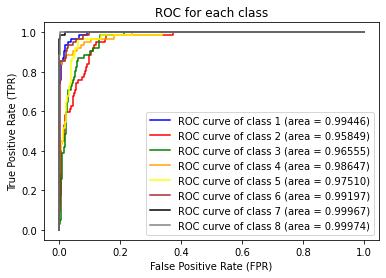

In [7]:
#Plot the classification ROC and AUC curves for each class
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
'''
To plot the ROC and AUC curves using sklearn, I went to their manual and noticed that the true values
need to be presented as one hot codes. 
'''

sample_row = [0, 0, 0, 0, 0, 0, 0, 0]
y_test_classes = np.array([])

for i in range(len(y_true)):
    if i==0:
        sample_row[y_true[i]] = 1
        y_test_classes = np.array([sample_row])
    else:
        sample_row[y_true[i]] = 1
        y_test_classes = np.vstack([y_test_classes, sample_row])
        
    sample_row = [0, 0, 0, 0, 0, 0, 0, 0]


'''
#The following plotting code was adapted and changed from the following source:
/***************************************************************************************
*    Title: ROC Curve explained using a COVID-19 hypothetical example: Binary & Multi-Class Classification tutorial
*    Author: Serafeim Loukas
*    Date: Jun 10, 2020
*    Code version: N/A
*    Availability: https://towardsdatascience.com/roc-curve-explained-using-a-covid-19-hypothetical-example-binary-multi-class-classification-bab188ea869c
*
***************************************************************************************/
'''

n_classes = 8
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_classes[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange', 'yellow', 'brown', 'black', 'grey', 'purple', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.5f})' ''.format(i+1, roc_auc[i]))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC for each class')
plt.legend(loc="lower right")
plt.show()

In [9]:
#Plot the normalized confusion matrix
from sklearn.metrics import confusion_matrix

predictions = [0]*len(y_pred)
for i in range(len(y_pred)):
    predictions[i] = np.argmax(y_pred[i])
predictions = np.array(predictions)

matrix = confusion_matrix(y_true, predictions)
np.set_printoptions(precision=2)

#To normalize the matrix, I had to normalize it relative to each class
matrix = matrix.astype('float')/matrix.sum(axis=1)[:,np.newaxis]
print(matrix)

[[0.85 0.   0.11 0.02 0.   0.02 0.   0.  ]
 [0.   0.76 0.08 0.   0.15 0.02 0.   0.  ]
 [0.   0.16 0.77 0.03 0.03 0.   0.   0.  ]
 [0.03 0.   0.11 0.85 0.   0.   0.   0.  ]
 [0.   0.32 0.   0.   0.66 0.02 0.   0.  ]
 [0.03 0.   0.08 0.02 0.05 0.82 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.95 0.05]
 [0.   0.   0.   0.   0.   0.   0.   1.  ]]


In [10]:
#Precision, Recall, and F-1 score on the test set

from sklearn.metrics import precision_score
precision = precision_score(y_true, predictions, labels=[1,2,3,4,5,6,7,8,9], average='micro')
print("The precision on the test set is " + str(precision))

from sklearn.metrics import recall_score
recall = recall_score(y_true, predictions, labels=[1,2,3,4,5,6,7,8,9], average='micro')
print("The recall on the test set is "+str(recall))

f_1 = (2 * precision * recall) / (precision + recall)
print("The F-1 score on the test set is "+str(f_1))

The precision on the test set is 0.8223234624145785
The recall on the test set is 0.8317972350230415
The F-1 score on the test set is 0.8270332187857962


# Explanation

In [11]:
from xai_utils import *
test_generator.reset()
image_batch,label_batch=test_generator.next()
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']
index=8
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.96617067


# TASK 3 Q2

## Applying LIME to Unique Classes from Histopathological Test Set

In [49]:
from lime import lime_image
import matplotlib.pyplot as plt

'''
Task 3 Q2

The following code simply obtains 1 mask from LIME for each unique case for plotting the relevant features
that the model focuses on.
'''

lime_predicted = []
lime_correct = []
all_masks =[]
explain_model = lime_image.LimeImageExplainer()
test_generator.reset()
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']
index=1
for i in range(8):
    # Only want to look at each class once so I call .next() twice because same class appears in two successive batch
    image_batch,label_batch=test_generator.next()
    image_batch,label_batch=test_generator.next() 
    
    prediction=model(image_batch)
    lime_predicted.append(classes[np.argmax(label_batch[index])])
    lime_correct.append(classes[np.argmax(prediction[index])])
    print('True label: '+classes[np.argmax(label_batch[index])])
    print('Predicted_label: '+classes[np.argmax(prediction[index])])
    print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
    
    explainer = explain_model.explain_instance(image_batch[index], model.predict, top_labels=2, hide_color=1, num_samples=100)
    
    # I had to do .astype and normalization to plot the masks similar to RISE
    mask=mask.astype('float32')
    mask -= mask.min()
    mask /= mask.max()+10e-30
    
    image, mask = explainer.get_image_and_mask(explainer.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    all_masks.append(mask)

True label: Tumor
Predicted_label: Complex
Confidence score for the correct label: 0.2342313


  0%|          | 0/100 [00:00<?, ?it/s]

True label: Stroma
Predicted_label: Debris
Confidence score for the correct label: 0.28122768


  0%|          | 0/100 [00:00<?, ?it/s]

True label: Complex
Predicted_label: Lympho
Confidence score for the correct label: 0.15871437


  0%|          | 0/100 [00:00<?, ?it/s]

True label: Lympho
Predicted_label: Lympho
Confidence score for the correct label: 0.9030197


  0%|          | 0/100 [00:00<?, ?it/s]

True label: Debris
Predicted_label: Debris
Confidence score for the correct label: 0.8096088


  0%|          | 0/100 [00:00<?, ?it/s]

True label: Mucosa
Predicted_label: Mucosa
Confidence score for the correct label: 0.768982


  0%|          | 0/100 [00:00<?, ?it/s]

True label: Adiopse
Predicted_label: Adiopse
Confidence score for the correct label: 0.9816851


  0%|          | 0/100 [00:00<?, ?it/s]

True label: Empty
Predicted_label: Empty
Confidence score for the correct label: 0.9018407


  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Predicted: Empty | Correct: Empty')

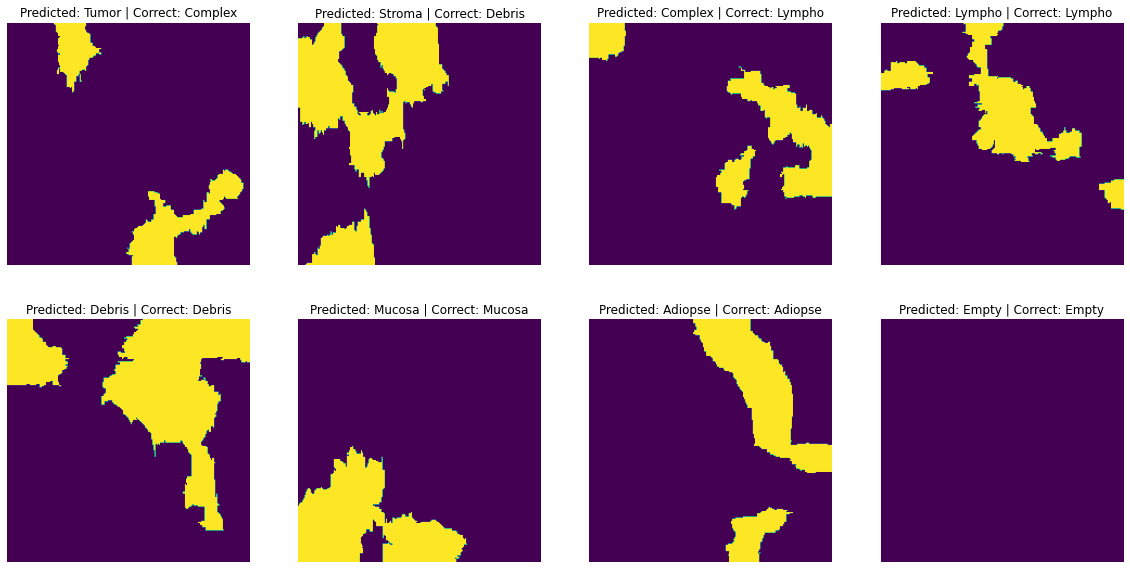

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

plt.subplot(2,4,1)
plt.imshow(all_masks[0])
plt.axis('off')
plt.title('Predicted: '+ lime_predicted[0]+ " | Correct: "+ lime_correct[0])

plt.subplot(2,4,2)
plt.imshow(all_masks[1])
plt.axis('off')
plt.title('Predicted: '+ lime_predicted[1]+ " | Correct: "+ lime_correct[1])

plt.subplot(2,4,3)
plt.imshow(all_masks[2])
plt.axis('off')
plt.title('Predicted: '+ lime_predicted[2]+ " | Correct: "+ lime_correct[2])

plt.subplot(2,4,4)
plt.imshow(all_masks[3])
plt.axis('off')
plt.title('Predicted: '+ lime_predicted[3]+ " | Correct: "+ lime_correct[3])

plt.subplot(2,4,5)
plt.imshow(all_masks[4])
plt.axis('off')
plt.title('Predicted: '+ lime_predicted[4]+ " | Correct: "+ lime_correct[4])

plt.subplot(2,4,6)
plt.imshow(all_masks[5])
plt.axis('off')
plt.title('Predicted: '+ lime_predicted[5]+ " | Correct: "+ lime_correct[5])

plt.subplot(2,4,7)
plt.imshow(all_masks[6])
plt.axis('off')
plt.title('Predicted: '+ lime_predicted[6]+ " | Correct: "+ lime_correct[6])

plt.subplot(2,4,8)
plt.imshow(all_masks[7])
plt.axis('off')
plt.title('Predicted: '+ lime_predicted[7]+ " | Correct: "+ lime_correct[7])


## Applying RISE to Unique Classes from Histopathological Test Set

In [51]:
'''
Task 3 Q2

The following code simply obtains 1 map from RISE for each unique case for plotting the relevant features
that the model focuses on.
'''

rise_predicted = []
rise_correct = []
all_maps =[]
explain_model = lime_image.LimeImageExplainer()
test_generator.reset()
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']
index=1
for i in range(8):
    image_batch,label_batch=test_generator.next()
    image_batch,label_batch=test_generator.next() # Only want to look at each class once so I call .next() twice
    
    prediction=model(image_batch)
    rise_predicted.append(classes[np.argmax(label_batch[index])])
    rise_correct.append(classes[np.argmax(prediction[index])])
    print('True label: '+classes[np.argmax(label_batch[index])])
    print('Predicted_label: '+classes[np.argmax(prediction[index])])
    print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
    
    explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]), N_MASKS=200)
    explanation_map_RISE -= explanation_map_RISE.min()
    explanation_map_RISE /= explanation_map_RISE.max()+10e-30

    all_maps.append(explanation_map_RISE)

True label: Tumor
Predicted_label: Complex
Confidence score for the correct label: 0.2342313
True label: Stroma
Predicted_label: Debris
Confidence score for the correct label: 0.28122768
True label: Complex
Predicted_label: Lympho
Confidence score for the correct label: 0.15871437
True label: Lympho
Predicted_label: Lympho
Confidence score for the correct label: 0.9030197
True label: Debris
Predicted_label: Debris
Confidence score for the correct label: 0.8096088
True label: Mucosa
Predicted_label: Mucosa
Confidence score for the correct label: 0.768982
True label: Adiopse
Predicted_label: Adiopse
Confidence score for the correct label: 0.9816851
True label: Empty
Predicted_label: Empty
Confidence score for the correct label: 0.9018407
CPU times: user 2min 33s, sys: 36.5 s, total: 3min 10s
Wall time: 32.7 s


Text(0.5, 1.0, 'Predicted: Empty | Correct: Empty')

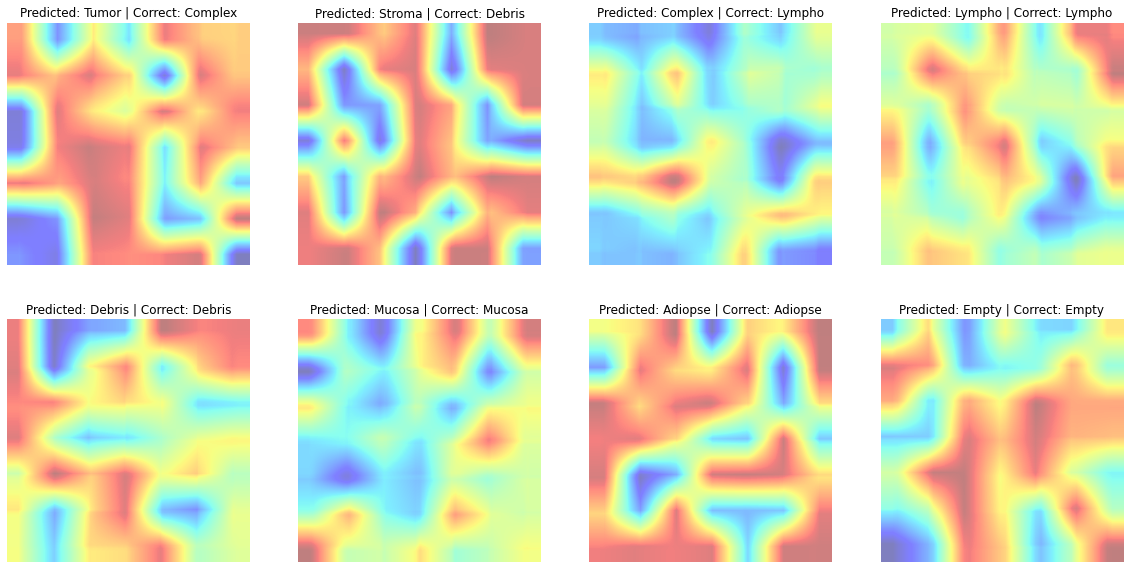

In [63]:
#Plot the results
plt.figure(figsize=(20,10))

plt.subplot(2,4,1)
plt.imshow(all_maps[0], cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Predicted: '+ rise_predicted[0]+ " | Correct: "+ rise_correct[0])

plt.subplot(2,4,2)
plt.imshow(all_maps[1], cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Predicted: '+ rise_predicted[1]+ " | Correct: "+ rise_correct[1])

plt.subplot(2,4,3)
plt.imshow(all_maps[2], cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Predicted: '+ rise_predicted[2]+ " | Correct: "+ rise_correct[2])

plt.subplot(2,4,4)
plt.imshow(all_maps[3], cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Predicted: '+ rise_predicted[3]+ " | Correct: "+ rise_correct[3])

plt.subplot(2,4,5)
plt.imshow(all_maps[4], cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Predicted: '+ rise_predicted[4]+ " | Correct: "+ rise_correct[4])

plt.subplot(2,4,6)
plt.imshow(all_maps[5], cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Predicted: '+ rise_predicted[5]+ " | Correct: "+ rise_correct[5])

plt.subplot(2,4,7)
plt.imshow(all_maps[6], cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Predicted: '+ rise_predicted[6]+ " | Correct: "+ rise_correct[6])

plt.subplot(2,4,8)
plt.imshow(all_maps[7], cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Predicted: '+ rise_predicted[7]+ " | Correct: "+ rise_correct[7])


# TASK 4

## Quantitative evaluation of the explanation algorithm

In [65]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

## Drop and Increase Rate with RISE

In [80]:
%%time

'''
This code goes through all the test dataset and computes the average drop rate and increase rate using RISE.
Each batch contains 32 datapoints and for every batch we compute its drop and increase values, store them,
and later compute their average.
'''
test_generator.reset()
drop_total_RISE = 0
increase_total_RISE = 0
for i in range(15):
    image_batch,label_batch=test_generator.next()
    prediction=model(image_batch)
    print("Working on batch ", str(i))
    
    for index in range(32):
        explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]),N_MASKS=100)
        explanation_map_RISE -= explanation_map_RISE.min()
        explanation_map_RISE /= explanation_map_RISE.max()+10e-30
        
        drop, increase, ori_pred, exp_pred = calculate_drop_increase(image_batch[index:index+1], model, explanation_map_RISE, 
                                class_index=np.argmax(prediction[index]), frac=0.9)
        drop_total_RISE+=drop
        increase_total_RISE+=increase

Working on batch  0
Working on batch  1
Working on batch  2
Working on batch  3
Working on batch  4
Working on batch  5
Working on batch  6
Working on batch  7
Working on batch  8
Working on batch  9
Working on batch  10
Working on batch  11
Working on batch  12
Working on batch  13
Working on batch  14
CPU times: user 1h 6min 55s, sys: 11min 42s, total: 1h 18min 38s
Wall time: 14min 2s


In [81]:
print(drop_total_RISE/(15*32))
print(increase_total_RISE/(15*32))

0.544974486892499
0.16875


## Drop and Increase Rate with LIME

In [82]:
%%time

'''
This code goes through all the test dataset and computes the average drop rate and increase rate using LIME.
Each batch contains 32 datapoints and for every batch we compute its drop and increase values, store them,
and later compute their average.
'''

from lime import lime_image
test_generator.reset()

explain_model = lime_image.LimeImageExplainer()

drop_total_LIME = 0
increase_total_LIME = 0
for i in range(15):
    image_batch,label_batch=test_generator.next()
    prediction=model(image_batch)
    print("Working on batch ", str(i))
    
    for index in range(32):
        explainer = explain_model.explain_instance(image_batch[index], model.predict, 
                                           top_labels=2, hide_color=0, num_samples=100)

        image, mask = explainer.get_image_and_mask(explainer.top_labels[0], 
                                           positive_only=True, num_features=5, hide_rest=True)
        mask=mask.astype('float32')
        mask -= mask.min()
        mask /= mask.max()+10e-30

        drop, increase, ori_pred, exp_pred = calculate_drop_increase(image_batch[index:index+1], model, mask, 
                                class_index=np.argmax(prediction[index]), frac=0.9)
        drop_total_LIME+=drop
        increase_total_LIME+=increase

Working on batch  0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  6


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  7


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  8


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  9


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  10


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  11


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  12


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  13


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Working on batch  14


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1h 11min 42s, sys: 16min 51s, total: 1h 28min 33s
Wall time: 23min 17s


In [83]:
print(drop_total_LIME/(15*32))
print(increase_total_LIME/(15*32))

0.8812499684853957
0.11875


In [267]:
layers = [['conv2d_3']]
test_generator.reset()
drop_rate = 0.
increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[0]
        increase_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[1]

drop_rate /= (15*32)
increase_rate /= (15*32)

0
0
0
0
2
0
0
0
0
0
0
0
0
3
0
5
0
0
0
0
0
0
2
0
0
0
0
0
0
2
0
0
0
2
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
2
0
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
2
1
1
1
1
1
1
1
1
4
1
1
1
1
2
4
1
1
4
1
1
1
4
1
1
1
4
4
1
1
1
4
4
1
1
1
1
5
1
2
1
1
2
2
2
2
2
2
4
2
2
2
4
2
2
1
2
2
1
2
1
2
2
1
2
2
2
1
2
2
2
2
2
2
1
1
2
2
2
3
2
2
2
2
3
2
2
2
1
2
2
2
2
2
2
2
2
1
1
2
2
2
2
2
2
3
3
3
3
3
3
3
2
3
3
3
3
3
2
3
3
3
3
2
3
3
3
2
3
3
3
3
3
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
2
3
3
3
3
3
0
3
3
1
1
5
1
4
4
1
4
4
1
1
1
1
4
4
1
4
4
4
1
4
4
4
4
4
1
4
4
4
4
4
1
4
4
4
1
4
1
4
4
1
4
4
4
4
4
1
4
4
1
4
1
4
4
4
4
1
4
4
4
4
1
5
5
5
5
5
5
5
5
4
2
5
5
5
5
5
5
5
5
5
5
5
5
4
5
5
5
5
5
5
2
5
5
0
3
5
5
0
5
5
2
5
5
5
5
5
5
5
2
4
5
5
5
5
5
5
2
5
5
5
5
5
5
6
6
7
7
6
6
6
6
6
6
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


In [268]:
print(drop_rate)
print(increase_rate)

0.59773367667
0.17916666666666667
